In [0]:
# Define storage details
container_name = "rawmoleculebindai"
storage_account_name = "moleculebindai"
connection_string = "DefaultEndpointsProtocol=https;AccountName=moleculebindai;AccountKey=7VPodD0gJ92a3mkxVQJjlEpeaYsjPEVTHRb2BcfGV5jUf2l8aFq51b+BoSzbrqJrcZxOqxQvn/mu+ASt7R4E6w==;EndpointSuffix=core.windows.net"

# Extract the account key from the connection string
account_key = [part.split("=", 1)[1] for part in connection_string.split(";") if part.startswith("AccountKey")][0]

# Configure Spark to use the account key
spark.conf.set(
    f"fs.azure.account.key.{storage_account_name}.blob.core.windows.net",
    account_key
)

# Define the Blob Storage URL
storage_url = f"wasbs://{container_name}@{storage_account_name}.blob.core.windows.net"

# Path to your dataset
data_path = f"{storage_url}/train.csv"

# Read the dataset
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Show the first few rows
display(df)

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:136)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:136)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:717)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

In [0]:
df.printSchema()
df.show(5)

root
 |-- id: integer (nullable = true)
 |-- buildingblock1_smiles: string (nullable = true)
 |-- buildingblock2_smiles: string (nullable = true)
 |-- buildingblock3_smiles: string (nullable = true)
 |-- molecule_smiles: string (nullable = true)
 |-- protein_name: string (nullable = true)
 |-- binds: integer (nullable = true)

+---+---------------------+---------------------+---------------------+--------------------+------------+-----+
| id|buildingblock1_smiles|buildingblock2_smiles|buildingblock3_smiles|     molecule_smiles|protein_name|binds|
+---+---------------------+---------------------+---------------------+--------------------+------------+-----+
|  0| C#CC[C@@H](CC(=O)...| C#CCOc1ccc(CN)cc1.Cl| Br.Br.NCC1CCCN1c1...|C#CCOc1ccc(CNc2nc...|        BRD4|    0|
|  1| C#CC[C@@H](CC(=O)...| C#CCOc1ccc(CN)cc1.Cl| Br.Br.NCC1CCCN1c1...|C#CCOc1ccc(CNc2nc...|         HSA|    0|
|  2| C#CC[C@@H](CC(=O)...| C#CCOc1ccc(CN)cc1.Cl| Br.Br.NCC1CCCN1c1...|C#CCOc1ccc(CNc2nc...|         sEH|    0|

+-----+---------+
|binds|    count|
+-----+---------+
|    1|  1589906|
|    0|293656924|
+-----+---------+



<Axes: xlabel='binds'>

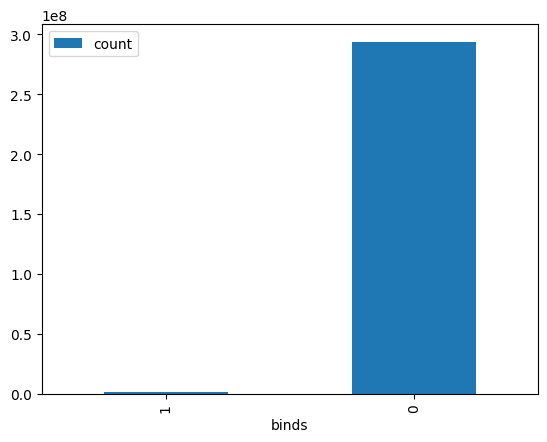

In [0]:
df.groupBy('binds').count().show()
bindDist=df.groupBy('binds').count().toPandas()
bindDist.plot.bar(x='binds',y='count')

+------------+--------+
|protein_name|   count|
+------------+--------+
|         HSA|98415610|
|        BRD4|98415610|
|         sEH|98415610|
+------------+--------+



<Axes: xlabel='protein_name'>

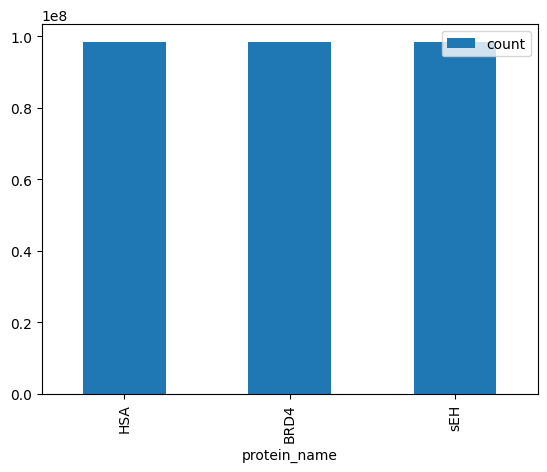

In [0]:
df.groupBy("protein_name").count().show()
protein_distribution = df.groupBy("protein_name").count().toPandas()


In [0]:
from pyspark.sql.functions import col, isnan, when, count
df.select([
    count(
        when(
            col(c).isNull() | (isnan(c) if df.schema[c].dataType in ['DoubleType', 'FloatType'] else False), 
            c
        )
    ).alias(c) 
    for c in df.columns
]).show()

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:136)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:136)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:717)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

In [0]:
%pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/32.7 MB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.4/32.7 MB 11.8 MB/s eta 0:00:03
   ━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/32.7 MB 15.6 MB/s eta 0:00:03
   ━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/32.7 MB 19.0 MB/s eta 0:00:02
   ━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/32.7 MB 23.1 MB/s eta 0:00:02
   ━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/32.7 MB 27.3 MB/s eta 0:00:02
   ━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/32.7 MB 33.4 MB/s eta 0:00:01
   ━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/32.7 MB 41.4 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━ 14.1/32.7 MB 83.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━ 19.6/32.7 MB 132.1 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━ 26.0/32.7 MB 172.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 32.6/32.7 MB 188.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 32.7/32.7 MB 182.6 M

In [0]:
from rdkit import Chem
from pyspark.sql.functions import pandas_udf
from pyspark.sql.types import BooleanType

# Define a Pandas UDF for SMILES validation
@pandas_udf(BooleanType())
def validate_smiles_pandas(smiles_series):
    return smiles_series.apply(lambda smiles: Chem.MolFromSmiles(smiles) is not None)

# Add the validation column using the Pandas UDF
df = df.withColumn("valid_smiles", validate_smiles_pandas(df["molecule_smiles"]))

# Count invalid SMILES strings
df.groupBy("valid_smiles").count().show()


com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:136)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:136)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:717)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

In [0]:
df.describe().show()


+-------+--------------------+---------------------+---------------------+---------------------+--------------------+------------+--------------------+
|summary|                  id|buildingblock1_smiles|buildingblock2_smiles|buildingblock3_smiles|     molecule_smiles|protein_name|               binds|
+-------+--------------------+---------------------+---------------------+---------------------+--------------------+------------+--------------------+
|  count|           295246830|            295246830|            295246830|            295246830|           295246830|   295246830|           295246830|
|   mean|1.4762341450000003E8|                 NULL|                 NULL|                 NULL|                NULL|        NULL|0.005385006165857902|
| stddev| 8.523041853327937E7|                 NULL|                 NULL|                 NULL|                NULL|        NULL| 0.07318475177653021|
|    min|                   0| C#CC[C@@H](CC(=O)...| C#CCOc1ccc(CN)cc1.Cl| Br.Br.NCC1CCC

In [0]:
print(f"Number of duplicates: {df.count() - df.dropDuplicates().count()}")


com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:434)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:458)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:706)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:508)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:613)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:636)
	at com.databricks.logging.AttributionContextTracing.$anonfun$withAttributionContext$1(AttributionContextTracing.scala:49)
	at com.databricks.logging.AttributionContext$.$anonfun$withValue$1(AttributionContext.scala:295)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(Attr

In [0]:
df.groupBy("protein_name", "binds").count().show()


+------------+-----+--------+
|protein_name|binds|   count|
+------------+-----+--------+
|         sEH|    1|  724532|
|         HSA|    1|  408410|
|         HSA|    0|98007200|
|         sEH|    0|97691078|
|        BRD4|    0|97958646|
|        BRD4|    1|  456964|
+------------+-----+--------+



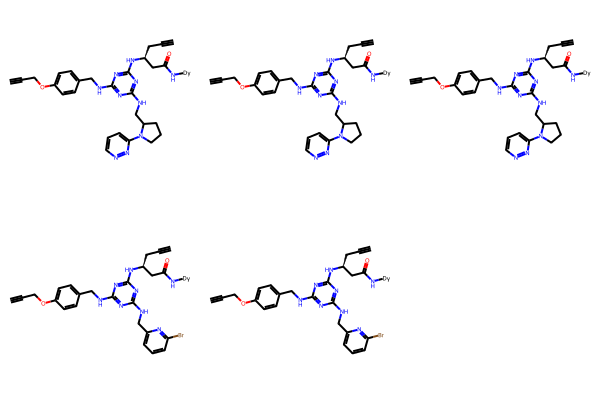

In [0]:
from rdkit.Chem import Draw

sample_smiles = df.select("molecule_smiles").limit(5).toPandas()["molecule_smiles"]
mols = [Chem.MolFromSmiles(smile) for smile in sample_smiles]
Draw.MolsToGridImage(mols, molsPerRow=3)


### Insights from Your EDA Results:

Let’s break down what your EDA reveals about the dataset and how it informs preprocessing and modeling:

---

### **1. Class Distribution (Binds Column)**

- **Observation**:
  - Total rows: ~295 million.
  - Binders (`binds = 1`): ~1.59 million (~0.54% of total data).
  - Non-binders (`binds = 0`): ~293.7 million (~99.46% of total data).

- **Insight**:
  - The dataset is **highly imbalanced**, with binders being extremely rare.
  - Imbalance at this level means:
    - A naïve model might predict "non-binding" for all examples and still achieve >99% accuracy.
    - Special techniques like **oversampling** the minority class, **undersampling** the majority class, or using **class-weighted loss functions** are necessary to ensure the model learns to recognize binders effectively.

- **Actionable Steps**:
  - Consider **stratified sampling** to create a balanced subset for local testing.
  - Use **evaluation metrics** like precision, recall, or F1 score rather than accuracy to assess model performance.

---

### **2. Protein Representation**

- **Observation**:
  - The dataset has equal representation across the three proteins:
    - **HSA**: ~98.4 million rows.
    - **BRD4**: ~98.4 million rows.
    - **sEH**: ~98.4 million rows.

- **Insight**:
  - The balanced representation ensures that all three proteins are equally represented in training, reducing bias toward one target.
  - **BRD4** has fewer binders (~456,964) compared to **sEH** (~724,532) and **HSA** (~408,410).

- **Actionable Steps**:
  - If modeling each protein separately, be aware of the variation in binding proportions across proteins.
  - Analyze why BRD4 has the fewest binders—it could be due to the chemical or structural properties of its binding pocket.

---

### **3. Descriptive Statistics**

- **Observation**:
  - The `binds` column has a mean value of **0.0054**, confirming the extreme imbalance.
  - Other columns (`buildingblock1_smiles`, `buildingblock2_smiles`, etc.) seem well-populated (no missing values in the counts).

- **Insight**:
  - The lack of missing data simplifies preprocessing—no need for imputation.
  - The numerical `id` column doesn’t provide any meaningful features for the model and can be ignored during training.

- **Actionable Steps**:
  - Focus on the **SMILES strings** and **protein_name** as features for modeling.
  - Drop the `id` column unless it is needed for tracking results.

---

### **4. Protein-Wise Binding Analysis**

- **Observation**:
  - For each protein:
    - **HSA**: 408,410 binders (~0.41%) vs. 98.0 million non-binders.
    - **sEH**: 724,532 binders (~0.73%) vs. 97.6 million non-binders.
    - **BRD4**: 456,964 binders (~0.46%) vs. 97.9 million non-binders.

- **Insight**:
  - The proportion of binders varies slightly by protein:
    - **sEH** has the highest proportion of binders, making it relatively easier to model.
    - **BRD4** has the lowest proportion, making it harder to model binding accurately.
  - This variation suggests that different proteins might require **separate models** or **protein-specific feature engineering**.

- **Actionable Steps**:
  - Consider building **individual models for each protein** to account for differences in binding dynamics.
  - Alternatively, include the `protein_name` as an input feature in a single, multi-target model.

---

### **5. SMILES Validation and Molecule Structures**

- **Observation**:
  - The visualized molecules show well-formed chemical structures, indicating valid SMILES strings for the examples provided.
  - There don’t seem to be any glaring issues with invalid SMILES (based on your sample).

- **Insight**:
  - The dataset’s chemical information is intact and ready for feature extraction.
  - This reduces the need for extensive cleaning or validation in this area.

- **Actionable Steps**:
  - Use a library like **RDKit** to compute molecular descriptors (e.g., fingerprints, molecular weight) from SMILES strings.
  - Consider advanced feature extraction methods like converting SMILES to **graph representations** for use with Graph Neural Networks (GNNs).

---


### **6. Visualized Molecular Structures**

- **Observation**:
  - The visualized molecules appear complex, with multiple functional groups and structural diversity.
  - The dataset contains molecules with rich chemical diversity, which is good for model generalization.

- **Insight**:
  - Complex molecules might be challenging for the model to learn without proper feature engineering.
  - Feature extraction methods like molecular fingerprints or embeddings will capture this diversity.

- **Actionable Steps**:
  - Use **ECFP fingerprints** or **pre-trained embeddings** (e.g., Mol2Vec or ChemBERTa) for molecule representation.
  - Ensure features capture structural diversity without oversimplification.

---

### **Summary of Key Insights and Next Steps**

1. **Imbalance**:
   - The dataset is highly imbalanced; focus on oversampling, undersampling, or class-weighted loss functions.

2. **Protein Differences**:
   - Binding proportions vary by protein; consider protein-specific models or features.

3. **No Missing Data**:
   - The dataset is complete, reducing preprocessing complexity.

4. **SMILES Strings**:
   - Molecules are valid and diverse, making it suitable for advanced molecular feature extraction.

5. **Focus Areas**:
   - Drop unnecessary columns (`id`).
   - Extract meaningful features from SMILES and protein names.
   - Check for duplicates before training.



In [0]:
%pip install dask
%pip install "dask[dataframe]"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.3 MB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 1.3/1.3 MB 47.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/56.4 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 2.2.1
    Not uninstalling cloudpickle at /databricks/python3/lib/python3.12/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-c0def5c4-3c12-4d52-9ca6-bf2286b4a305
    Can't uninstall 'cloudpickle'. No files were found to uninstall.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
%pip install rdkit

  Using cached rdkit-2024.3.6-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (4.0 kB)
Using cached rdkit-2024.3.6-cp312-cp312-manylinux_2_28_x86_64.whl (32.7 MB)
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField, ArrayType, FloatType, IntegerType
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem

# Define UDFs to compute molecular descriptors and fingerprints
def compute_descriptors(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        return {
            "MolWt": float(Descriptors.MolWt(mol)),
            "LogP": float(Descriptors.MolLogP(mol)),
            "NumHDonors": float(Descriptors.NumHDonors(mol)),
            "NumHAcceptors": float(Descriptors.NumHAcceptors(mol)),
            "TPSA": float(Descriptors.TPSA(mol)),
            "NumRotatableBonds": float(Descriptors.NumRotatableBonds(mol))
        }
    except Exception as e:
        return None

def compute_fingerprint(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
        return [int(bit) for bit in fp]
    except Exception as e:
        return None

# Define schemas for the outputs
descriptor_schema = StructType([
    StructField("MolWt", FloatType(), True),
    StructField("LogP", FloatType(), True),
    StructField("NumHDonors", FloatType(), True),
    StructField("NumHAcceptors", FloatType(), True),
    StructField("TPSA", FloatType(), True),
    StructField("NumRotatableBonds", FloatType(), True),
])

fingerprint_schema = ArrayType(IntegerType())

# Register the UDFs
descriptor_udf = udf(compute_descriptors, descriptor_schema)
fingerprint_udf = udf(compute_fingerprint, fingerprint_schema)

# Apply the UDFs to the molecule_smiles column
df_with_features = df.withColumn("Descriptors", descriptor_udf(df.molecule_smiles))
df_with_features = df_with_features.withColumn("Fingerprint", fingerprint_udf(df.molecule_smiles))

# Save the result back to Azure Blob Storage
output_path = f"{storage_url}/processed_train.parquet"
df_with_features.write.parquet(output_path, mode="overwrite")

print(f"Feature engineering complete. Processed data saved to {output_path}")


com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:136)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:136)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:717)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

In [0]:
from pyspark.sql.types import StructType, StructField, StringType, ArrayType, IntegerType, MapType, FloatType
from pyspark.sql.functions import pandas_udf, col
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
import pandas as pd

# UDF to compute molecular descriptors
def compute_descriptors(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return {
                "MolWt": float(Descriptors.MolWt(mol)),
                "LogP": float(Descriptors.MolLogP(mol)),
                "NumHDonors": float(Descriptors.NumHDonors(mol)),
                "NumHAcceptors": float(Descriptors.NumHAcceptors(mol)),
                "TPSA": float(Descriptors.TPSA(mol)),
                "NumRotatableBonds": float(Descriptors.NumRotatableBonds(mol))
            }
    except Exception:
        pass
    return {"MolWt": 0.0, "LogP": 0.0, "NumHDonors": 0.0, "NumHAcceptors": 0.0, "TPSA": 0.0, "NumRotatableBonds": 0.0}

# UDF to compute fingerprints
def compute_fingerprints(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
            return [int(x) for x in fp]
    except Exception:
        pass
    return [0] * 1024

# Define schemas
descriptor_schema = MapType(StringType(), FloatType())
fingerprint_schema = ArrayType(IntegerType())

# Register UDFs
@pandas_udf(descriptor_schema)
def descriptors_udf(smiles_series: pd.Series) -> pd.Series:
    return smiles_series.apply(compute_descriptors)

@pandas_udf(fingerprint_schema)
def fingerprints_udf(smiles_series: pd.Series) -> pd.Series:
    return smiles_series.apply(compute_fingerprints)

# Apply UDFs to process the dataset
processed_df = (
    df.withColumn("Descriptors", descriptors_udf(col("molecule_smiles")))
      .withColumn("Fingerprints", fingerprints_udf(col("molecule_smiles")))
)

# Save the processed data back to Azure Blob Storage
output_path = f"{storage_url}/processed_train.parquet"
processed_df.write.parquet(output_path, mode="overwrite", compression="snappy")

print(f"Feature engineering complete. Processed data saved to {output_path}")


com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:136)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:136)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:717)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

In [0]:
%python
from pyspark.sql.types import StructType, StructField, StringType, ArrayType, IntegerType, MapType, FloatType
from pyspark.sql.functions import pandas_udf, col
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
import pandas as pd

# UDF to compute molecular descriptors
def compute_descriptors(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return {
                "MolWt": float(Descriptors.MolWt(mol)),
                "LogP": float(Descriptors.MolLogP(mol)),
                "NumHDonors": float(Descriptors.NumHDonors(mol)),
                "NumHAcceptors": float(Descriptors.NumHAcceptors(mol)),
                "TPSA": float(Descriptors.TPSA(mol)),
                "NumRotatableBonds": float(Descriptors.NumRotatableBonds(mol))
            }
    except Exception:
        pass
    return {"MolWt": 0.0, "LogP": 0.0, "NumHDonors": 0.0, "NumHAcceptors": 0.0, "TPSA": 0.0, "NumRotatableBonds": 0.0}

# UDF to compute fingerprints
def compute_fingerprints(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
            return [int(x) for x in fp]
    except Exception:
        pass
    return [0] * 1024

# Define schemas
descriptor_schema = MapType(StringType(), FloatType())
fingerprint_schema = ArrayType(IntegerType())

# Register UDFs
@pandas_udf(descriptor_schema)
def descriptors_udf(smiles_series: pd.Series) -> pd.Series:
    return smiles_series.apply(compute_descriptors)

@pandas_udf(fingerprint_schema)
def fingerprints_udf(smiles_series: pd.Series) -> pd.Series:
    return smiles_series.apply(compute_fingerprints)

# Apply UDFs to process the dataset
processed_df = (
    df.withColumn("Descriptors", descriptors_udf(col("molecule_smiles")))
      .withColumn("Fingerprints", fingerprints_udf(col("molecule_smiles")))
)

# Save the processed data back to Azure Blob Storage
output_path = f"{storage_url}/processed_train.parquet"
processed_df.write.parquet(output_path, mode="overwrite", compression="snappy")

print(f"Feature engineering complete. Processed data saved to {output_path}")

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:136)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:136)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:717)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

In [0]:
from pyspark.sql.types import StructType, StructField, StringType, ArrayType, IntegerType, MapType, FloatType
from pyspark.sql.functions import pandas_udf, col
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
import pandas as pd

# UDF to compute molecular descriptors
def compute_descriptors(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return {
                "MolWt": float(Descriptors.MolWt(mol)),
                "LogP": float(Descriptors.MolLogP(mol)),
                "NumHDonors": float(Descriptors.NumHDonors(mol)),
                "NumHAcceptors": float(Descriptors.NumHAcceptors(mol)),
                "TPSA": float(Descriptors.TPSA(mol)),
                "NumRotatableBonds": float(Descriptors.NumRotatableBonds(mol))
            }
    except Exception:
        pass
    return {"MolWt": 0.0, "LogP": 0.0, "NumHDonors": 0.0, "NumHAcceptors": 0.0, "TPSA": 0.0, "NumRotatableBonds": 0.0}

# UDF to compute fingerprints
def compute_fingerprints(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
            return [int(x) for x in fp]
    except Exception:
        pass
    return [0] * 1024

# Define schemas
descriptor_schema = MapType(StringType(), FloatType())
fingerprint_schema = ArrayType(IntegerType())

# Register UDFs
@pandas_udf(descriptor_schema)
def descriptors_udf(smiles_series: pd.Series) -> pd.Series:
    return smiles_series.apply(compute_descriptors)

@pandas_udf(fingerprint_schema)
def fingerprints_udf(smiles_series: pd.Series) -> pd.Series:
    return smiles_series.apply(compute_fingerprints)

# Take a small sample from the dataset (1 chunk for testing)
test_chunk = df.limit(1000)

# Apply UDFs to process the chunk
processed_test_chunk = (
    test_chunk.withColumn("Descriptors", descriptors_udf(col("molecule_smiles")))
              .withColumn("Fingerprints", fingerprints_udf(col("molecule_smiles")))
)

# Save the processed chunk to Azure Blob Storage
test_output_path = f"{storage_url}/processed_test_chunk.parquet"
processed_test_chunk.write.parquet(test_output_path, mode="overwrite", compression="snappy")

print(f"Feature engineering test complete. Processed test chunk saved to {test_output_path}")


Feature engineering test complete. Processed test chunk saved to wasbs://rawmoleculebindai@moleculebindai.blob.core.windows.net/processed_test_chunk.parquet


In [0]:
from pyspark.sql.types import StructType, StructField, StringType, ArrayType, IntegerType, MapType, FloatType
from pyspark.sql.functions import udf, col
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem

# Define native UDF to compute molecular descriptors
def compute_descriptors(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return {
                "MolWt": float(Descriptors.MolWt(mol)),
                "LogP": float(Descriptors.MolLogP(mol)),
                "NumHDonors": float(Descriptors.NumHDonors(mol)),
                "NumHAcceptors": float(Descriptors.NumHAcceptors(mol)),
                "TPSA": float(Descriptors.TPSA(mol)),
                "NumRotatableBonds": float(Descriptors.NumRotatableBonds(mol))
            }
    except Exception:
        pass
    return {"MolWt": 0.0, "LogP": 0.0, "NumHDonors": 0.0, "NumHAcceptors": 0.0, "TPSA": 0.0, "NumRotatableBonds": 0.0}

# Define native UDF to compute fingerprints
def compute_fingerprints(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
            return [int(x) for x in fp]
    except Exception:
        pass
    return [0] * 1024

# Define schemas
descriptor_schema = MapType(StringType(), FloatType())
fingerprint_schema = ArrayType(IntegerType())

# Register the UDFs
descriptor_udf = udf(compute_descriptors, descriptor_schema)
fingerprint_udf = udf(compute_fingerprints, fingerprint_schema)

# Take a small sample from the dataset (1 chunk for testing)
test_chunk = df.limit(1000)

# Apply the UDFs to process the chunk
processed_test_chunk = (
    test_chunk.withColumn("Descriptors", descriptor_udf(col("molecule_smiles")))
              .withColumn("Fingerprints", fingerprint_udf(col("molecule_smiles")))
)

# Save the processed chunk to Azure Blob Storage
test_output_path = f"{storage_url}/processed_test_chunk_native_udf.parquet"
processed_test_chunk.write.parquet(test_output_path, mode="overwrite", compression="snappy")

print(f"Feature engineering test complete. Processed test chunk saved to {test_output_path}")


Feature engineering test complete. Processed test chunk saved to wasbs://rawmoleculebindai@moleculebindai.blob.core.windows.net/processed_test_chunk_native_udf.parquet


In [0]:
from pyspark.sql.functions import pandas_udf, PandasUDFType, col
from pyspark.sql.types import ArrayType, IntegerType, MapType, StringType, FloatType
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
import pandas as pd

# Function to compute fingerprints
def compute_fingerprints(smiles, fp_size=1024):
    results = []
    for s in smiles:
        try:
            mol = Chem.MolFromSmiles(s)
            if mol:
                fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=fp_size)
                results.append([int(bit) for bit in fp.ToBitString()])  # Ensure integers
            else:
                results.append([0] * fp_size)  # Default for invalid SMILES
        except Exception:
            results.append([0] * fp_size)  # Default for errors
    return pd.Series(results)

# Function to compute molecular descriptors
def compute_descriptors(smiles):
    default_descriptor = {
        "LogP": 0.0,
        "TPSA": 0.0,
        "MolWt": 0.0,
        "NumHDonors": 0.0,
        "NumHAcceptors": 0.0,
        "NumRotatableBonds": 0.0
    }
    results = []
    for s in smiles:
        try:
            mol = Chem.MolFromSmiles(s)
            if mol:
                descriptors = {
                    "LogP": float(Descriptors.MolLogP(mol)),
                    "TPSA": float(Descriptors.TPSA(mol)),
                    "MolWt": float(Descriptors.MolWt(mol)),
                    "NumHDonors": float(Descriptors.NumHDonors(mol)),
                    "NumHAcceptors": float(Descriptors.NumHAcceptors(mol)),
                    "NumRotatableBonds": float(Descriptors.NumRotatableBonds(mol))
                }
                results.append(descriptors)
            else:
                results.append(default_descriptor)
        except Exception:
            results.append(default_descriptor)
    return pd.Series(results)

# Register the UDFs with Spark
@pandas_udf(ArrayType(IntegerType()), PandasUDFType.SCALAR)
def fingerprints_udf(smiles):
    return compute_fingerprints(smiles)

@pandas_udf(MapType(StringType(), FloatType()), PandasUDFType.SCALAR)
def descriptors_udf(smiles):
    return compute_descriptors(smiles)

# Undersample data to achieve a manageable dataset size
positive_df = df.filter(df.binds == 1)
negative_df = df.filter(df.binds == 0).sample(fraction=0.001, seed=42)  # Adjust fraction as needed
undersampled_df = positive_df.union(negative_df)

# Drop unnecessary columns
undersampled_df = undersampled_df.drop("buildingblock1_smiles", "buildingblock2_smiles", "buildingblock3_smiles")

# Apply fingerprints and descriptors UDFs to the DataFrame
processed_df = (
    undersampled_df.withColumn("fingerprints", fingerprints_udf(col("molecule_smiles")))
                   .withColumn("descriptors", descriptors_udf(col("molecule_smiles")))
)

# Chunk-based processing (already leveraged by Spark's partitioning)
data_splits = processed_df.randomSplit([0.1] * 10, seed=42)  # Adjust splits as needed

# Save each chunk to Parquet
for i, chunk in enumerate(data_splits):
    print(f"Processing chunk {i + 1}/{len(data_splits)}...")

    output_path = f"{storage_url}/processed_chunk_{i}.parquet"
    chunk.write.parquet(output_path, mode="overwrite", compression="snappy")
    print(f"Chunk {i + 1} saved to {output_path}.")

print("Feature engineering and saving completed.")


/databricks/spark/python/pyspark/sql/pandas/functions.py:443: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(
/databricks/spark/python/pyspark/sql/pandas/functions.py:443: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


Processing chunk 1/10...


com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:136)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:136)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:717)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

In [0]:
# Import necessary libraries
from pyspark.sql.functions import pandas_udf, col
from pyspark.sql.types import ArrayType, IntegerType, MapType, StringType, FloatType
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
import pandas as pd

# Function to compute fingerprints
def compute_fingerprints(smiles, fp_size=1024):
    results = []
    for s in smiles:
        try:
            mol = Chem.MolFromSmiles(s)
            if mol:
                fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=fp_size)
                results.append([int(bit) for bit in fp.ToBitString()])  # Ensure integers
            else:
                results.append([0] * fp_size)  # Default for invalid SMILES
        except Exception:
            results.append([0] * fp_size)  # Default for errors
    return pd.Series(results)

# Function to compute molecular descriptors
def compute_descriptors(smiles):
    default_descriptor = {
        "LogP": 0.0,
        "TPSA": 0.0,
        "MolWt": 0.0,
        "NumHDonors": 0.0,
        "NumHAcceptors": 0.0,
        "NumRotatableBonds": 0.0
    }
    results = []
    for s in smiles:
        try:
            mol = Chem.MolFromSmiles(s)
            if mol:
                descriptors = {
                    "LogP": float(Descriptors.MolLogP(mol)),
                    "TPSA": float(Descriptors.TPSA(mol)),
                    "MolWt": float(Descriptors.MolWt(mol)),
                    "NumHDonors": float(Descriptors.NumHDonors(mol)),
                    "NumHAcceptors": float(Descriptors.NumHAcceptors(mol)),
                    "NumRotatableBonds": float(Descriptors.NumRotatableBonds(mol))
                }
                results.append(descriptors)
            else:
                results.append(default_descriptor)
        except Exception:
            results.append(default_descriptor)
    return pd.Series(results)

# Register the UDFs with Spark
@pandas_udf(ArrayType(IntegerType()), PandasUDFType.SCALAR)
def fingerprints_udf(smiles):
    return compute_fingerprints(smiles)

@pandas_udf(MapType(StringType(), FloatType()), PandasUDFType.SCALAR)
def descriptors_udf(smiles):
    return compute_descriptors(smiles)

filtered_df = df.filter(df.protein_name == 'HSA')
positive_df = filtered_df.filter(filtered_df.binds == 1)
negative_df = filtered_df.filter(filtered_df.binds == 0)
negative_df_sampled = negative_df.sample(fraction=0.7, seed=42)

# Combine positive and undersampled negative samples
undersampled_df = positive_df.union(negative_df_sampled)

# Drop unnecessary columns
undersampled_df = undersampled_df.drop("buildingblock1_smiles", "buildingblock2_smiles", "buildingblock3_smiles")

# Apply fingerprints and descriptors UDFs to the DataFrame
processed_df = (
    undersampled_df.withColumn("fingerprints", fingerprints_udf(col("molecule_smiles")))
                   .withColumn("descriptors", descriptors_udf(col("molecule_smiles")))
)

# Save the processed test chunk to Parquet
output_path = f"{storage_url}/HSA_features/processed_test_chunk_HSA.parquet"
processed_df.write.parquet(output_path, mode="overwrite", compression="snappy")

print(f"Test processing complete. Processed test chunk saved to {output_path}.")


/databricks/spark/python/pyspark/sql/pandas/functions.py:443: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


Test processing complete. Processed test chunk saved to wasbs://rawmoleculebindai@moleculebindai.blob.core.windows.net/HSA_features/processed_test_chunk_HSA.parquet.


In [0]:
from pyspark.sql.functions import pandas_udf, col
from pyspark.sql.types import ArrayType, IntegerType, MapType, StringType, FloatType
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
import pandas as pd


def compute_fingerprints(smiles, fp_size=1024):
    results = []
    for s in smiles:
        try:
            mol = Chem.MolFromSmiles(s)
            if mol:
                fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=fp_size)
                results.append([int(bit) for bit in fp.ToBitString()])  # Ensure integers
            else:
                results.append([0] * fp_size)  # Default for invalid SMILES
        except Exception:
            results.append([0] * fp_size)  # Default for errors
    return pd.Series(results)

def compute_descriptors(smiles):
    default_descriptor = {
        "LogP": 0.0,
        "TPSA": 0.0,
        "MolWt": 0.0,
        "NumHDonors": 0.0,
        "NumHAcceptors": 0.0,
        "NumRotatableBonds": 0.0
    }
    results = []
    for s in smiles:
        try:
            mol = Chem.MolFromSmiles(s)
            if mol:
                descriptors = {
                    "LogP": float(Descriptors.MolLogP(mol)),
                    "TPSA": float(Descriptors.TPSA(mol)),
                    "MolWt": float(Descriptors.MolWt(mol)),
                    "NumHDonors": float(Descriptors.NumHDonors(mol)),
                    "NumHAcceptors": float(Descriptors.NumHAcceptors(mol)),
                    "NumRotatableBonds": float(Descriptors.NumRotatableBonds(mol))
                }
                results.append(descriptors)
            else:
                results.append(default_descriptor)
        except Exception:
            results.append(default_descriptor)
    return pd.Series(results)

@pandas_udf(ArrayType(IntegerType()), PandasUDFType.SCALAR)
def fingerprints_udf(smiles):
    return compute_fingerprints(smiles)

@pandas_udf(MapType(StringType(), FloatType()), PandasUDFType.SCALAR)
def descriptors_udf(smiles):
    return compute_descriptors(smiles)

filtered_df = df.filter(df.protein_name == 'BRD4')
positive_df = filtered_df.filter(filtered_df.binds == 1)
negative_df = filtered_df.filter(filtered_df.binds == 0)
negative_df_sampled = negative_df.sample(fraction=0.7, seed=42)
undersampled_df = positive_df.union(negative_df_sampled)
undersampled_df = undersampled_df.drop("buildingblock1_smiles", "buildingblock2_smiles", "buildingblock3_smiles")
processed_df = (
    undersampled_df.withColumn("fingerprints", fingerprints_udf(col("molecule_smiles")))
                   .withColumn("descriptors", descriptors_udf(col("molecule_smiles")))
)
output_path = f"{storage_url}/BRD4_features/processed_test_chunk_BRD4.parquet"
processed_df.write.parquet(output_path, mode="overwrite", compression="snappy")
print(f"Test processing complete. Processed test chunk saved to {output_path}.")

/databricks/spark/python/pyspark/sql/pandas/functions.py:443: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


Test processing complete. Processed test chunk saved to wasbs://rawmoleculebindai@moleculebindai.blob.core.windows.net/BRD4_features/processed_test_chunk_BRD4.parquet.


In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col
from pyspark.sql.types import FloatType
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.linalg import Vectors, VectorUDT
import json

# Initialize Spark session
spark = SparkSession.builder.appName("ViewProcessedData").getOrCreate()

# Define storage details
container_name = "rawmoleculebindai"
storage_account_name = "moleculebindai"
account_key = "7VPodD0gJ92a3mkxVQJjlEpeaYsjPEVTHRb2BcfGV5jUf2l8aFq51b+BoSzbrqJrcZxOqxQvn/mu+ASt7R4E6w=="
storage_url = f"wasbs://{container_name}@{storage_account_name}.blob.core.windows.net"

# Path to the processed data
processed_data_path = f"{storage_url}/HSA_features/processed_test_chunk_HSA.parquet"

# Configure Spark to use the account key
spark.conf.set(f"fs.azure.account.key.{storage_account_name}.blob.core.windows.net", account_key)

# Load the processed parquet file
processed_df = spark.read.parquet(processed_data_path)

# Drop unnecessary columns
columns_to_drop = ["molecule_smiles"]
processed_df = processed_df.drop(*columns_to_drop)

# Verify the remaining columns
print(f"Remaining columns: {processed_df.columns}")

Remaining columns: ['id', 'protein_name', 'binds', 'fingerprints', 'descriptors']


In [0]:
print(f"Remaining columns: {processed_df.columns}")

Remaining columns: ['id', 'protein_name', 'binds', 'fingerprints', 'descriptors']


In [0]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import FloatType
import json

# Define a UDF to extract a specific descriptor from the JSON field
def extract_descriptor_value(descriptor_json, key):
    try:
        return float(json.loads(descriptor_json)[key])
    except:
        return None

# List of descriptor keys
descriptor_keys = ['LogP', 'TPSA', 'MolWt', 'NumHDonors', 'NumHAcceptors', 'NumRotatableBonds']

# Add new columns for each descriptor
for key in descriptor_keys:
    processed_df = processed_df.withColumn(
        key, udf(lambda x: extract_descriptor_value(x, key), FloatType())(col("descriptors"))
    )


In [0]:
processed_df.select("descriptors").show(truncate=False, n=20)


+------------------------------------------------------------------------------------------------------------------------+
|descriptors                                                                                                             |
+------------------------------------------------------------------------------------------------------------------------+
|{LogP -> 3.98018, TPSA -> 174.89, MolWt -> 736.934, NumHDonors -> 3.0, NumHAcceptors -> 12.0, NumRotatableBonds -> 9.0} |
|{LogP -> 3.46698, TPSA -> 144.64, MolWt -> 692.925, NumHDonors -> 3.0, NumHAcceptors -> 11.0, NumRotatableBonds -> 8.0} |
|{LogP -> 2.81358, TPSA -> 144.64, MolWt -> 658.48, NumHDonors -> 3.0, NumHAcceptors -> 11.0, NumRotatableBonds -> 8.0}  |
|{LogP -> 3.46698, TPSA -> 144.64, MolWt -> 692.925, NumHDonors -> 3.0, NumHAcceptors -> 11.0, NumRotatableBonds -> 8.0} |
|{LogP -> 3.78748, TPSA -> 118.86, MolWt -> 676.029, NumHDonors -> 3.0, NumHAcceptors -> 9.0, NumRotatableBonds -> 8.0}  |
|{LogP -> 4.4108

In [0]:
for key in descriptor_keys:
    processed_df.select("descriptors", key).show(truncate=False, n=20)


+------------------------------------------------------------------------------------------------------------------------+----+
|descriptors                                                                                                             |LogP|
+------------------------------------------------------------------------------------------------------------------------+----+
|{LogP -> 3.98018, TPSA -> 174.89, MolWt -> 736.934, NumHDonors -> 3.0, NumHAcceptors -> 12.0, NumRotatableBonds -> 9.0} |NULL|
|{LogP -> 3.46698, TPSA -> 144.64, MolWt -> 692.925, NumHDonors -> 3.0, NumHAcceptors -> 11.0, NumRotatableBonds -> 8.0} |NULL|
|{LogP -> 2.81358, TPSA -> 144.64, MolWt -> 658.48, NumHDonors -> 3.0, NumHAcceptors -> 11.0, NumRotatableBonds -> 8.0}  |NULL|
|{LogP -> 3.46698, TPSA -> 144.64, MolWt -> 692.925, NumHDonors -> 3.0, NumHAcceptors -> 11.0, NumRotatableBonds -> 8.0} |NULL|
|{LogP -> 3.78748, TPSA -> 118.86, MolWt -> 676.029, NumHDonors -> 3.0, NumHAcceptors -> 9.0, NumRotatab

In [0]:
from pyspark.sql.functions import col

# Extract keys directly from the descriptors map
descriptor_keys = ['LogP', 'TPSA', 'MolWt', 'NumHDonors', 'NumHAcceptors', 'NumRotatableBonds']
for key in descriptor_keys:
    processed_df = processed_df.withColumn(key, col("descriptors").getItem(key))


In [0]:
for key in descriptor_keys:
    processed_df.select("descriptors", key).show(truncate=False, n=10)


+------------------------------------------------------------------------------------------------------------------------+-------+
|descriptors                                                                                                             |LogP   |
+------------------------------------------------------------------------------------------------------------------------+-------+
|{LogP -> 3.98018, TPSA -> 174.89, MolWt -> 736.934, NumHDonors -> 3.0, NumHAcceptors -> 12.0, NumRotatableBonds -> 9.0} |3.98018|
|{LogP -> 3.46698, TPSA -> 144.64, MolWt -> 692.925, NumHDonors -> 3.0, NumHAcceptors -> 11.0, NumRotatableBonds -> 8.0} |3.46698|
|{LogP -> 2.81358, TPSA -> 144.64, MolWt -> 658.48, NumHDonors -> 3.0, NumHAcceptors -> 11.0, NumRotatableBonds -> 8.0}  |2.81358|
|{LogP -> 3.46698, TPSA -> 144.64, MolWt -> 692.925, NumHDonors -> 3.0, NumHAcceptors -> 11.0, NumRotatableBonds -> 8.0} |3.46698|
|{LogP -> 3.78748, TPSA -> 118.86, MolWt -> 676.029, NumHDonors -> 3.0, NumHAccepto

In [0]:
from pyspark.ml.feature import VectorAssembler

descriptor_assembler = VectorAssembler(
    inputCols=descriptor_keys,
    outputCol="descriptor_features"
)
processed_df = descriptor_assembler.transform(processed_df)


In [0]:
processed_df = processed_df.na.drop(subset=['LogP', 'TPSA', 'MolWt', 'NumHDonors', 'NumHAcceptors', 'NumRotatableBonds'])
print(f"Rows after dropping null descriptors: {processed_df.count()}")


Rows after dropping null descriptors: 69011738


In [0]:
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT

# UDF to convert array to DenseVector
def array_to_dense_vector(array):
    return Vectors.dense(array) if array else None

array_to_dense_vector_udf = udf(array_to_dense_vector, VectorUDT())

processed_df = processed_df.withColumn(
    "fingerprint_features", array_to_dense_vector_udf(col("fingerprints"))
)


In [0]:
processed_df = processed_df.na.drop(subset=["fingerprint_features"])


In [0]:
processed_df.select("descriptor_features", "fingerprint_features").show(truncate=False, n=5)


+---------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [0]:
processed_df.schema

StructType([StructField('id', IntegerType(), True), StructField('protein_name', StringType(), True), StructField('binds', IntegerType(), True), StructField('fingerprints', ArrayType(IntegerType(), True), True), StructField('descriptors', MapType(StringType(), FloatType(), True), True), StructField('LogP', FloatType(), True), StructField('TPSA', FloatType(), True), StructField('MolWt', FloatType(), True), StructField('NumHDonors', FloatType(), True), StructField('NumHAcceptors', FloatType(), True), StructField('NumRotatableBonds', FloatType(), True), StructField('descriptor_features', VectorUDT(), True), StructField('fingerprint_features', VectorUDT(), True)])

In [0]:
# Import necessary libraries
from pyspark.ml.feature import StandardScaler

# Drop columns that are no longer needed
columns_to_drop = ["descriptors", "fingerprints",]
processed_df = processed_df.drop(*columns_to_drop)

# Split the data into train and test sets (adjust the split ratio as needed)
train_df, test_df = processed_df.randomSplit([0.8, 0.2], seed=42)

In [0]:
train_df.printSchema()


root
 |-- id: integer (nullable = true)
 |-- protein_name: string (nullable = true)
 |-- binds: integer (nullable = true)
 |-- LogP: float (nullable = true)
 |-- TPSA: float (nullable = true)
 |-- MolWt: float (nullable = true)
 |-- NumHDonors: float (nullable = true)
 |-- NumHAcceptors: float (nullable = true)
 |-- NumRotatableBonds: float (nullable = true)
 |-- descriptor_features: vector (nullable = true)
 |-- fingerprint_features: vector (nullable = true)



In [0]:


# StandardScaler for descriptor features
descriptor_scaler = StandardScaler(
    inputCol="descriptor_features",
    outputCol="scaled_descriptor_features",
    withStd=True,
    withMean=True
)
descriptor_model = descriptor_scaler.fit(train_df)
train_df = descriptor_model.transform(train_df)
test_df = descriptor_model.transform(test_df)  # Use the same scaler for test data

# StandardScaler for fingerprint features
fingerprint_scaler = StandardScaler(
    inputCol="fingerprint_features",
    outputCol="scaled_fingerprint_features",
    withStd=True,
    withMean=False
)
fingerprint_model = fingerprint_scaler.fit(train_df)
train_df = fingerprint_model.transform(train_df)
test_df = fingerprint_model.transform(test_df)  # Use the same scaler for test data

# Drop columns that are no longer needed after scaling
columns_to_drop_after_scaling = ["descriptor_features", "fingerprint_features"]
train_df = train_df.drop(*columns_to_drop_after_scaling)
test_df = test_df.drop(*columns_to_drop_after_scaling)

# Save the cleaned and scaled training data
output_parquet_path_train = f"{storage_url}/HSA_features/train/StandardScalerprocessedHSAtrain.parquet"
train_df.write.parquet(output_parquet_path_train, mode="overwrite", compression="snappy")

# Save the cleaned and scaled testing data
output_parquet_path_test = f"{storage_url}/HSA_features/test/StandardScalerprocessedHSAtest.parquet"
test_df.write.parquet(output_parquet_path_test, mode="overwrite", compression="snappy")

print("Training and testing datasets have been processed, scaled, and saved.")


Training and testing datasets have been processed, scaled, and saved.


In [0]:
from pyspark.ml.linalg import Vectors

# Sample input data for testing
test_data = [
    (1, [3.78, 118.86, 676.02, 3.0, 9.0, 8.0], [0.0, 1.0, 0.0, 1.0]),
    (2, [4.1, 120.45, 700.30, 4.0, 10.0, 7.0], [1.0, 0.0, 0.0, 1.0]),
]
columns = ["id", "descriptor_features", "fingerprint_features"]

# Create a test DataFrame
test_df = spark.createDataFrame(test_data, schema=columns)

# Convert arrays to vectors
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT

array_to_vector_udf = udf(lambda x: Vectors.dense(x), VectorUDT())

test_df = test_df.withColumn("descriptor_features", array_to_vector_udf("descriptor_features"))
test_df = test_df.withColumn("fingerprint_features", array_to_vector_udf("fingerprint_features"))

# Transform the sample data using the loaded models
transformed_descriptor = descriptor_model.transform(test_df)
transformed_final = fingerprint_model.transform(transformed_descriptor)

# Show the transformed sample data
transformed_final.select("scaled_descriptor_features", "scaled_fingerprint_features").show(truncate=False)


+------------------------------------------------------------------------------------------------------------------------+---------------------------------------------+
|scaled_descriptor_features                                                                                              |scaled_fingerprint_features                  |
+------------------------------------------------------------------------------------------------------------------------+---------------------------------------------+
|[0.0883863259372809,-1.5229044583720541,-0.9255528864966303,-1.8982508447697881,-1.3187998656053919,-1.316460884305313] |[0.0,2.004684625978048,0.0,4.568654326018994]|
|[0.2960760972563826,-1.4645666979062282,-0.5903033495079929,-0.5924848478997587,-0.7234946834901972,-1.7862173301172821]|[7.038883583745279,0.0,0.0,4.568654326018994]|
+------------------------------------------------------------------------------------------------------------------------+---------------------------------

In [0]:
train_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- protein_name: string (nullable = true)
 |-- binds: integer (nullable = true)
 |-- LogP: float (nullable = true)
 |-- TPSA: float (nullable = true)
 |-- MolWt: float (nullable = true)
 |-- NumHDonors: float (nullable = true)
 |-- NumHAcceptors: float (nullable = true)
 |-- NumRotatableBonds: float (nullable = true)
 |-- scaled_descriptor_features: vector (nullable = true)
 |-- scaled_fingerprint_features: vector (nullable = true)



In [0]:
# Select only the necessary columns
train_df = train_df.select("scaled_descriptor_features", "scaled_fingerprint_features", "binds")

# Show the updated schema
train_df.printSchema()

# Display the first 5 rows to verify
train_df.show(5)


root
 |-- scaled_descriptor_features: vector (nullable = true)
 |-- scaled_fingerprint_features: vector (nullable = true)
 |-- binds: integer (nullable = true)

+--------------------------+---------------------------+-----+
|scaled_descriptor_features|scaled_fingerprint_features|binds|
+--------------------------+---------------------------+-----+
|      [-1.4188216523450...|       [0.0,0.0,0.0,4.56...|    0|
|      [-1.0206281933218...|       [0.0,0.0,0.0,0.0,...|    0|
|      [-0.2776580843211...|       [0.0,0.0,0.0,0.0,...|    0|
|      [-0.8307154132052...|       [0.0,0.0,0.0,0.0,...|    0|
|      [-0.2093777568490...|       [0.0,0.0,0.0,0.0,...|    0|
+--------------------------+---------------------------+-----+
only showing top 5 rows


In [0]:
%pip install xgboost lightgbm


Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
%pip install azure-storage-blob fsspec adlfs


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/41.8 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/183.9 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/55.3 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.5.0
    Not uninstalling fsspec at /databricks/python3/lib/python3.12/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-1a245ee8-7cae-4946-8918-8e825ae3f73c
    Can't uninstall 'fsspec'. No files were found to uninstall.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.1.0 requires fsspec[http]<=2024.9.0,>=2023

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, rand, expr
from pyspark.ml.functions import vector_to_array
from pyspark.ml.feature import PCA
from xgboost.spark import SparkXGBClassifier
from pyspark.sql.types import ArrayType, FloatType
from pyspark.sql.functions import array_repeat, size, greatest

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("XGBoost on Spark") \
    .getOrCreate()

# Azure Blob Storage Configuration
container_name = "rawmoleculebindai"
storage_account_name = "moleculebindai"
connection_string = "DefaultEndpointsProtocol=https;AccountName=moleculebindai;AccountKey=7VPodD0gJ92a3mkxVQJjlEpeaYsjPEVTHRb2BcfGV5jUf2l8aFq51b+BoSzbrqJrcZxOqxQvn/mu+ASt7R4E6w==;EndpointSuffix=core.windows.net"

# Extract the account key from the connection string
account_key = [part.split("=", 1)[1] for part in connection_string.split(";") if part.startswith("AccountKey")][0]

# Configure Spark
spark.conf.set(f"fs.azure.account.key.{storage_account_name}.blob.core.windows.net", account_key)

# Define storage URL and paths
storage_url = f"wasbs://{container_name}@{storage_account_name}.blob.core.windows.net"
train_parquet_path = f"{storage_url}/HSA_features/train/StandardScalerprocessedHSAtrain.parquet"
test_parquet_path = f"{storage_url}/HSA_features/test/StandardScalerprocessedHSAtest.parquet"

# Load data in Spark
train_df = spark.read.parquet(train_parquet_path)
test_df = spark.read.parquet(test_parquet_path)

# Preview schema and data
train_df.printSchema()
test_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- protein_name: string (nullable = true)
 |-- binds: integer (nullable = true)
 |-- LogP: float (nullable = true)
 |-- TPSA: float (nullable = true)
 |-- MolWt: float (nullable = true)
 |-- NumHDonors: float (nullable = true)
 |-- NumHAcceptors: float (nullable = true)
 |-- NumRotatableBonds: float (nullable = true)
 |-- scaled_descriptor_features: vector (nullable = true)
 |-- scaled_fingerprint_features: vector (nullable = true)

root
 |-- id: integer (nullable = true)
 |-- protein_name: string (nullable = true)
 |-- binds: integer (nullable = true)
 |-- LogP: float (nullable = true)
 |-- TPSA: float (nullable = true)
 |-- MolWt: float (nullable = true)
 |-- NumHDonors: float (nullable = true)
 |-- NumHAcceptors: float (nullable = true)
 |-- NumRotatableBonds: float (nullable = true)
 |-- scaled_descriptor_features: vector (nullable = true)
 |-- scaled_fingerprint_features: vector (nullable = true)



In [0]:
# Model 1: Using scaled_descriptor_features
model1_df = train_df.select("scaled_descriptor_features", "binds").withColumnRenamed("scaled_descriptor_features", "features")
model1_df = model1_df.dropna()

# Debug Model 1 Data
print("Model 1 DataFrame Schema:")
model1_df.printSchema()
print("\nSample data for Model 1:")
model1_df.show(5, truncate=False)

Model 1 DataFrame Schema:
root
 |-- features: vector (nullable = true)
 |-- binds: integer (nullable = true)


Sample data for Model 1:
+-------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                 |binds|
+-------------------------------------------------------------------------------------------------------------------------+-----+
|[1.2669562870016524,-0.3716160630032127,0.5879718967579226,-0.5925406025858753,-0.7235035739596957,1.5021293769178334]   |0    |
|[0.8191622127040453,-1.081570765704672,-0.16363052315916302,-0.5925406025858753,-1.3188231641832742,1.0323683852123169]  |0    |
|[0.9259444550873864,-1.2771293533930321,0.8734541297350834,-0.5925406025858753,-0.7235035739596957,2.4416513603288665]   |0    |
|[0.624602406961986,-1.4814934996486595,-0.1079565195443704,-0.5925406025858753,-1.3

In [0]:
# Model 2: Using scaled_fingerprint_features
model2_df = train_df.select("scaled_fingerprint_features", "binds").withColumnRenamed("scaled_fingerprint_features", "features")
model2_df = model2_df.dropna()

# Debug Model 2 Data
print("Model 2 DataFrame Schema:")
model2_df.printSchema()
print("\nSample data for Model 2:")
model2_df.show(5, truncate=False)

Model 2 DataFrame Schema:
root
 |-- features: vector (nullable = true)
 |-- binds: integer (nullable = true)


Sample data for Model 2:
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [0]:
print("Missing values in Model 1:")
model1_df.select([col(c).isNull().cast("int").alias(c) for c in model1_df.columns]).show()

print("Missing values in Model 2:")
model2_df.select([col(c).isNull().cast("int").alias(c) for c in model2_df.columns]).show()


Missing values in Model 1:
+--------+-----+
|features|binds|
+--------+-----+
|       0|    0|
|       0|    0|
|       0|    0|
|       0|    0|
|       0|    0|
|       0|    0|
|       0|    0|
|       0|    0|
|       0|    0|
|       0|    0|
|       0|    0|
|       0|    0|
|       0|    0|
|       0|    0|
|       0|    0|
|       0|    0|
|       0|    0|
|       0|    0|
|       0|    0|
|       0|    0|
+--------+-----+
only showing top 20 rows
Missing values in Model 2:
+--------+-----+
|features|binds|
+--------+-----+
|       0|    0|
|       0|    0|
|       0|    0|
|       0|    0|
|       0|    0|
|       0|    0|
|       0|    0|
|       0|    0|
|       0|    0|
|       0|    0|
|       0|    0|
|       0|    0|
|       0|    0|
|       0|    0|
|       0|    0|
|       0|    0|
|       0|    0|
|       0|    0|
|       0|    0|
|       0|    0|
+--------+-----+
only showing top 20 rows


In [0]:
from pyspark.sql.functions import udf, expr
from pyspark.ml.linalg import Vectors, VectorUDT

# UDF to convert Vector to Array
def vector_to_array(vector):
    return vector.toArray().tolist()

vector_to_array_udf = udf(vector_to_array, ArrayType(DoubleType()))

# Convert VectorUDT to ArrayType
model1_df = model1_df.withColumn("features_array", vector_to_array_udf("features"))
model2_df = model2_df.withColumn("features_array", vector_to_array_udf("features"))

# Function to pad or truncate arrays to a fixed size
def pad_or_truncate(column, size):
    return expr(f"""
        concat(
            array_repeat(0.0, greatest(0, {size} - size({column}))),
            slice({column}, 1, {size})
        )
    """)

# Standardize dimensions: 6 for model1_df and 1024 for model2_df
model1_df = model1_df.withColumn("features_padded", pad_or_truncate("features_array", 6))
model2_df = model2_df.withColumn("features_padded", pad_or_truncate("features_array", 1024))

# Optional: Convert back to DenseVector if needed for MLlib models
def array_to_vector(array):
    return Vectors.dense(array)

array_to_vector_udf = udf(array_to_vector, VectorUDT())

model1_df = model1_df.withColumn("features", array_to_vector_udf("features_padded"))
model2_df = model2_df.withColumn("features", array_to_vector_udf("features_padded"))

# Drop intermediate columns
model1_df = model1_df.drop("features_array", "features_padded")
model2_df = model2_df.drop("features_array", "features_padded")


In [0]:
from pyspark.sql.functions import col
from pyspark.sql import DataFrame

def stratified_split(df: DataFrame, label_col: str, train_frac: float, seed: int = 42):
    """
    Perform stratified split on a DataFrame.

    :param df: Input DataFrame
    :param label_col: Name of the column with labels
    :param train_frac: Fraction of data to use for training
    :param seed: Random seed for reproducibility
    :return: Two DataFrames: train_df, test_df
    """
    # Get distinct class labels
    classes = df.select(label_col).distinct().collect()
    
    train_dfs = []
    test_dfs = []
    
    for cls in classes:
        # Filter rows of the current class
        class_label = cls[label_col]
        class_df = df.filter(col(label_col) == class_label)
        
        # Split into train and test
        train_class, test_class = class_df.randomSplit([train_frac, 1 - train_frac], seed=seed)
        
        # Append to lists
        train_dfs.append(train_class)
        test_dfs.append(test_class)
    
    # Union all classes to form train and test sets
    train_df = train_dfs[0].unionAll(*train_dfs[1:])
    test_df = test_dfs[0].unionAll(*test_dfs[1:])
    
    return train_df, test_df

# Apply stratified split to both model datasets
train_model1, test_model1 = stratified_split(model1_df, "binds", train_frac=0.8, seed=42)
train_model2, test_model2 = stratified_split(model2_df, "binds", train_frac=0.8, seed=42)


In [0]:
# Show 3 sample rows from train_model1
print("Sample rows from train_model1:")
train_model1.show(1, truncate=False)




Sample rows from train_model1:
+------------------------------------------------------------------------------------------------------------------+-----+---+
|features                                                                                                          |binds|dim|
+------------------------------------------------------------------------------------------------------------------+-----+---+
|[-4.038798915855361,3.129358358885949,-0.8429612430159561,4.630234522899076,1.0624551967110398,1.5021293769178334]|0    |6  |
+------------------------------------------------------------------------------------------------------------------+-----+---+
only showing top 1 row
Sample rows from train_model2:


com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:136)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:136)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:717)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

In [0]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Logistic Regression
lr_model1 = LogisticRegression(featuresCol="features", labelCol="binds")
lr_model1_fit = lr_model1.fit(train_model1)

# Predictions
lr_model1_predictions = lr_model1_fit.transform(test_model1)

# Evaluate Logistic Regression
evaluator = BinaryClassificationEvaluator(labelCol="binds", metricName="areaUnderROC")
lr_auc = evaluator.evaluate(lr_model1_predictions)

# Calculate Precision and Recall
lr_tp = lr_model1_predictions.filter((col("binds") == 1) & (col("prediction") == 1)).count()
lr_fp = lr_model1_predictions.filter((col("binds") == 0) & (col("prediction") == 1)).count()
lr_fn = lr_model1_predictions.filter((col("binds") == 1) & (col("prediction") == 0)).count()

lr_precision = lr_tp / (lr_tp + lr_fp) if (lr_tp + lr_fp) > 0 else 0
lr_recall = lr_tp / (lr_tp + lr_fn) if (lr_tp + lr_fn) > 0 else 0

print(f"Logistic Regression Metrics for Model 1:\nAUC: {lr_auc}\nPrecision: {lr_precision}\nRecall: {lr_recall}")


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

In [0]:
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("XGBoost on Spark") \
    .getOrCreate()

# Azure Blob Storage Configuration
container_name = "rawmoleculebindai"
storage_account_name = "moleculebindai"
connection_string = "DefaultEndpointsProtocol=https;AccountName=moleculebindai;AccountKey=7VPodD0gJ92a3mkxVQJjlEpeaYsjPEVTHRb2BcfGV5jUf2l8aFq51b+BoSzbrqJrcZxOqxQvn/mu+ASt7R4E6w==;EndpointSuffix=core.windows.net"

# Extract the account key from the connection string
account_key = [part.split("=", 1)[1] for part in connection_string.split(";") if part.startswith("AccountKey")][0]

# Configure Spark
spark.conf.set(f"fs.azure.account.key.{storage_account_name}.blob.core.windows.net", account_key)

# Define storage URL and paths
storage_url = f"wasbs://{container_name}@{storage_account_name}.blob.core.windows.net"
train_model1_path = f"{storage_url}/HSA_features/model/train/model1trainHSAtrain.parquet"
test_model1_path = f"{storage_url}/HSA_features/model/test/model1testHSAtest.parquet"
train_model2_path = f"{storage_url}/HSA_features/model/train/model2trainHSAtrain.parquet"
test_model2_path = f"{storage_url}/HSA_features/model/test/model2testHSAtest.parquet"

# Save the DataFrames as Parquet files
train_model1.write.mode("overwrite").parquet(train_model1_path)
print(f"Train Model 1 saved to: {train_model1_path}")

test_model1.write.mode("overwrite").parquet(test_model1_path)
print(f"Test Model 1 saved to: {test_model1_path}")

train_model2.write.mode("overwrite").parquet(train_model2_path)
print(f"Train Model 2 saved to: {train_model2_path}")

test_model2.write.mode("overwrite").parquet(test_model2_path)
print(f"Test Model 2 saved to: {test_model2_path}")


In [0]:
print(f"Logistic Regression Metrics for Model 1:\nAUC: {lr_auc}\nPrecision: {lr_precision}\nRecall: {lr_recall}")


In [0]:
from xgboost import XGBClassifier
import numpy as np

# Convert Spark DataFrame to Pandas for XGBoost
train_model1_pd = train_model1.select("features", "binds").toPandas()
test_model1_pd = test_model1.select("features", "binds").toPandas()

# Extract features and labels
X_train = np.array([row.toArray() for row in train_model1_pd["features"]])
y_train = train_model1_pd["binds"].values
X_test = np.array([row.toArray() for row in test_model1_pd["features"]])
y_test = test_model1_pd["binds"].values

# XGBoost Model
xgb_model1 = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb_model1.fit(X_train, y_train)

# Predictions
xgb_predictions = xgb_model1.predict(X_test)
xgb_probabilities = xgb_model1.predict_proba(X_test)[:, 1]

# Evaluate XGBoost
from sklearn.metrics import roc_auc_score, precision_score, recall_score

xgb_auc = roc_auc_score(y_test, xgb_probabilities)
xgb_precision = precision_score(y_test, xgb_predictions)
xgb_recall = recall_score(y_test, xgb_predictions)

print(f"XGBoost Metrics for Model 1:\nAUC: {xgb_auc}\nPrecision: {xgb_precision}\nRecall: {xgb_recall}")
